In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats 
import pandas as pd
from scipy.signal import find_peaks

### Non stationary value analysis of high tide water levels at Hoek van Holland
In this notebook, a non stationary extreme value analysis is performed for the water levels at Hoek van Holland. The data contains measurements of the high tide water levels observed between 1887 and 2020. In total, 94.162 measurements are collected. This overlaps with the high tide interval of just over 12 hours. 

First, the data is organized in a DataFrame and then plotted to observe the data.

In [3]:
df = pd.read_csv(
    'data/Meetreeks_HVH.txt',
    delim_whitespace=True,
    header=None,
    names=['Date', 'Time', 'Elevation'])

df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], dayfirst=True)

# Reorganize the DataFrame to have 'Datetime' as the first column
df = df[["Datetime", "Elevation"]]

df.head()

,Datetime,Elevation
0,1887-08-01 00:40:00,82
1,1887-08-01 13:10:00,72
2,1887-08-02 01:30:00,72
3,1887-08-02 14:20:00,72
4,1887-08-03 02:25:00,91


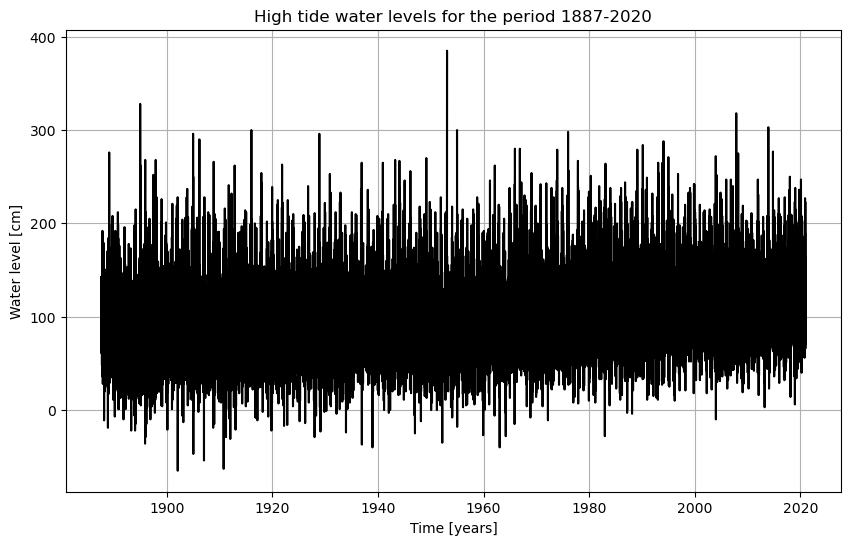

In [66]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('High tide water levels for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

Observing the plot for high tide water levels for the period 1887-2020, it can clearly be observed that the water levels become higher over the years. 
This aligns with the expectations regarding sea level rise. 

From this graph, an increase in mean water levels can be observed. There is no change observed in magnitude of the extreme values compared to the mean sea level. Therefore, the first hypothesis is that a stationary time series can be obtained by subtracting the yearly mean water levels from the observed water levels. 

First, the annual mean water levels are plotted for each year. Then a stationary time series is obtained by subtracting these annual means from the water level observations. Later on, it is testes wheter this assumption for stationarity is true. 

In [90]:
# Ensure Datetime is set as the index
df.set_index('Datetime', inplace=True)

# Add a 'Year' column for grouping
df['Year'] = df.index.year

# Calculate yearly averages
yearly_averages = df.groupby('Year')['Elevation'].mean()

# Map the yearly average back to the original DataFrame
df['Yearly_Avg'] = df['Year'].map(yearly_averages)

# Subtract the yearly average to obtain a stationary series
df['Elevation_Stationary'] = df['Elevation'] - df['Yearly_Avg']


# Drop the Year column if no longer needed
# df.drop(columns=['Year', 'Yearly_Avg'], inplace=True)

# Reset index if desired
df.reset_index(inplace=True)

mean_wl = df["Yearly_Avg"].mean()

print(df)

                 Datetime  Elevation  Year  Yearly_Avg  Elevation_Stationary
0     1887-08-01 00:40:00         82  1887   90.912162             -8.912162
1     1887-08-01 13:10:00         72  1887   90.912162            -18.912162
2     1887-08-02 01:30:00         72  1887   90.912162            -18.912162
3     1887-08-02 14:20:00         72  1887   90.912162            -18.912162
4     1887-08-03 02:25:00         91  1887   90.912162              0.087838
...                   ...        ...   ...         ...                   ...
94157 2020-12-29 14:15:00        130  2020  123.506365              6.493635
94158 2020-12-30 02:37:00        136  2020  123.506365             12.493635
94159 2020-12-30 14:46:00        148  2020  123.506365             24.493635
94160 2020-12-31 03:14:00        136  2020  123.506365             12.493635
94161 2020-12-31 15:27:00        144  2020  123.506365             20.493635

[94162 rows x 5 columns]


The average of the annual mean water level is 97.24 cm


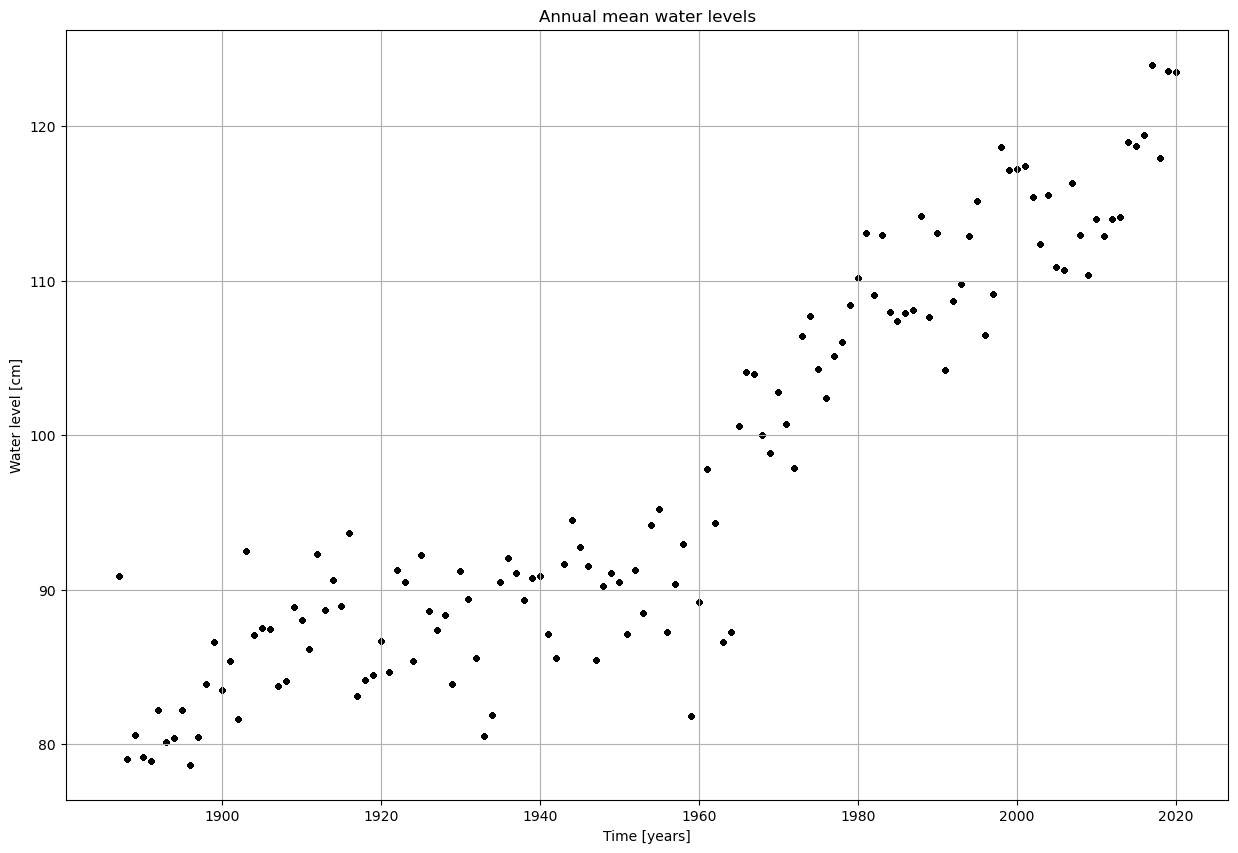

In [100]:
plt.figure(figsize=(15,10))
plt.scatter(df["Year"], df["Yearly_Avg"], color = 'black', marker= '.')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Annual mean water levels')
plt.grid()
plt.savefig('figures/timeseries.png')
print(f'The average of the annual mean water level is {mean_wl:.2f} cm')

5.312356215618939e-17


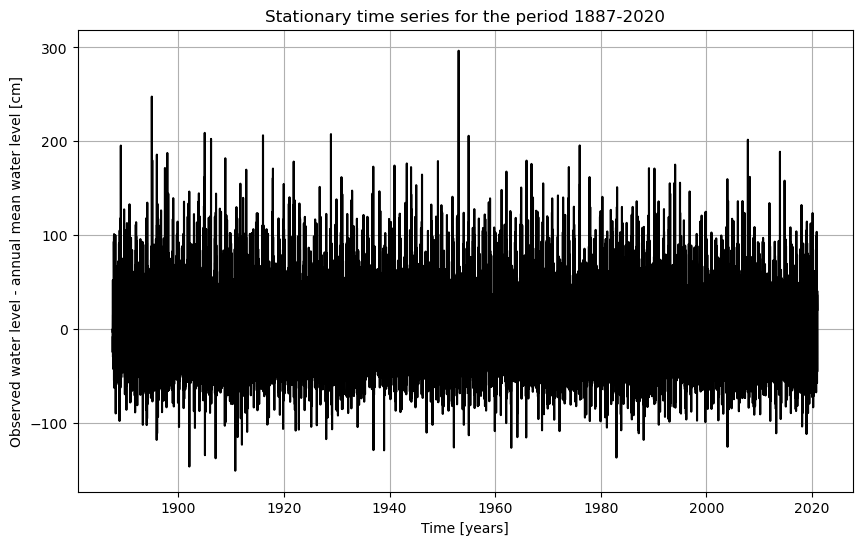

In [8]:
plt.figure(figsize=(10,6))
plt.plot(df["Datetime"], df["Elevation_Stationary"], color = 'black')
plt.xlabel('Time [years]')
plt.ylabel('Observed water level - annual mean water level [cm]')
plt.title('Stationary time series for the period 1887-2020')
plt.grid()
plt.savefig('figures/timeseries.png')

print(df["Elevation_Stationary"].mean())

In [9]:
# sea_level_correction = np.zeros(len(df["Elevation"]))
# for i in range(len(sea_level_correction) - 1):
#     if df["Datetime"][i+1].year != df["Datetime"][i].year:
#         if df["Datetime"][i].year < 1990:
#             sea_level_correction[i+1] = sea_level_correction[i] + 0.18
#         else:
#             sea_level_correction[i+1] = sea_level_correction[i] + 0.29
#     else:
#         sea_level_correction[i+1] = sea_level_correction[i]

# plt.plot(df["Datetime"], sea_level_correction)
# plt.title('Deltares model for mean sea level rise')

### Exploration of extreme values by block maxima
In this part, the extreme values of high tide water levels are further explored. First, block maxima are applied to find the maximum water levels per year. 

The yearly maxima are plotted over time. Except for the very extreme event during the watersnoodramp of 1953, the values range between 180 and 320 cm + NAP.  

Just like in the original time series, a shift in the mean can clearly be observed. 

The yearly maxima are also plotted on the timeseries. In this graph, it can be observed that there are a lot of peaks around 200-210 cm + NAP that the block maxima method does not capture. At the same time, it does capture yearly maxima as low as 180 cm + NAP, since there are no higher values observed within this year. 

For this reason, it makes more sense to apply the Peak Over Threshold method to determine the extreme values. 

The amount of the sampled extremes is: 134


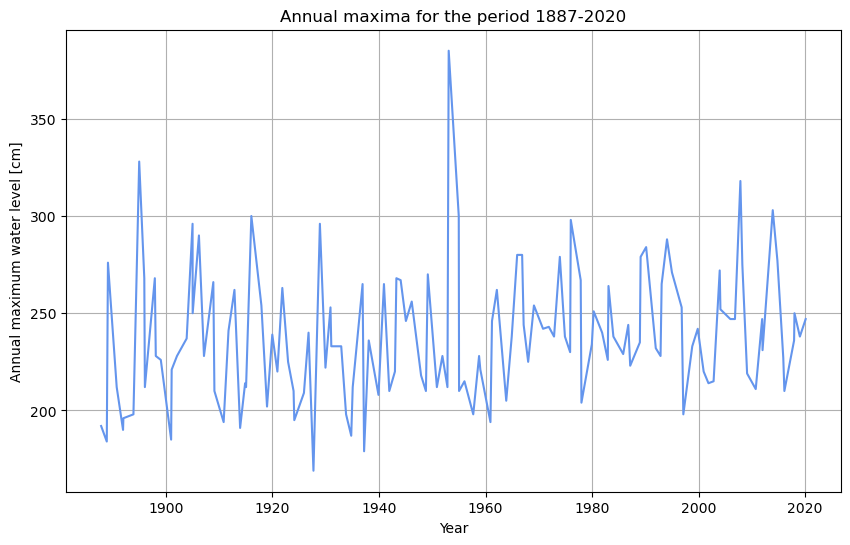

In [153]:
## Report yearly maxima for each year
idx_max = df.groupby(pd.DatetimeIndex(df['Datetime']).year)['Elevation'].idxmax()
YM = df.loc[idx_max]
print('The amount of the sampled extremes is:', YM.shape[0])

## Plot the yearly maxima
plt.figure(figsize=(10,6))
plt.plot(YM['Datetime'], YM['Elevation'], color = 'cornflowerblue')
plt.xlabel('Year')
plt.ylabel('Annual maximum water level [cm]')
plt.title('Annual maxima for the period 1887-2020')
plt.grid();
plt.savefig('figures/annualmax.png')

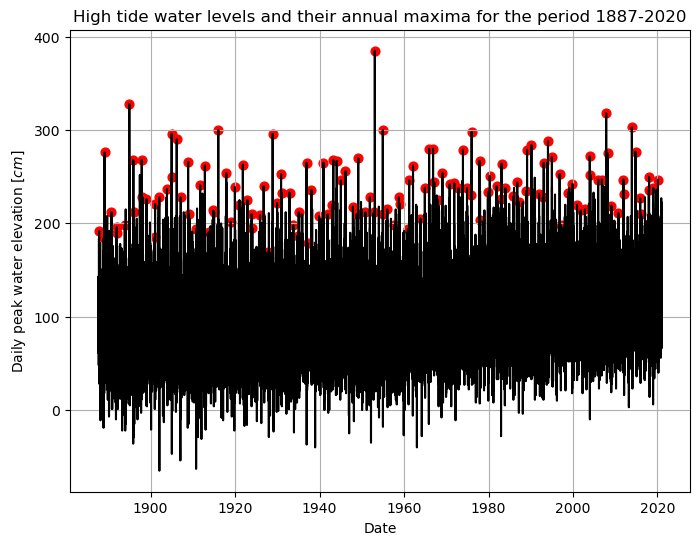

In [145]:
# Plot the yearly maxima on top of the time series
plt.figure(figsize=(8,6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(YM['Datetime'], YM['Elevation'], 40, 'r')
plt.xlabel('Date')
plt.ylabel('Daily peak water elevation [$cm$]')
plt.title('High tide water levels and their annual maxima for the period 1887-2020')
plt.grid()
plt.savefig('figures/YM_timeseries.png')

### Exploration of extreme values by Peak Over Threshold
To apply peak over threshold, the first step is to determine a threshold value. For Hoek van Holland, Rijkswaterstaat classifies water levels as normal until a maximum water level of 200 cm + NAP (waterinfo.rws.nl). 
Therefore a threshold of 200 cm + NAP is used to apply the peak over threshold extreme value analysis. 

To make sure that the same storm event is not counted multiple times, a declustering time is set for each event. The value of the declusering time is 4 days, as was applied in 'Probabilistic characterizations of flood hazards in deltas: Application to Hoek van Holland (Netherlands)' by Diakomopoulos et al. 
 

Threshold defined: 200 m.
Declustering time is: 96 hours.
The amount of the sampled extremes is: 207


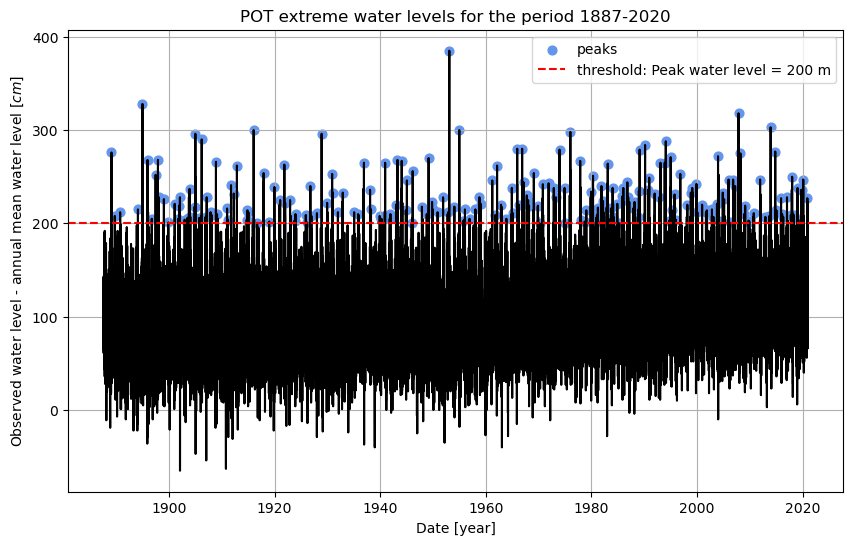

In [158]:
## Define the threshold
threshold = 200

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks_un, _ = find_peaks(df['Elevation'], height=threshold, distance=distance)
print('The amount of the sampled extremes is:', peaks_un.shape[0])

peak_times_un = df['Datetime'].iloc[peaks_un]
# exceedances_per_year = peak_times_un.groupby(peak_times_un.dt.year).size()

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation'],'k')
plt.scatter(df.iloc[peaks_un, 0], df.iloc[peaks_un, 1], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water level = {threshold} m')
plt.xlabel('Date [year]')
plt.ylabel('Observed water level - annual mean water level [$cm$]')
plt.legend()
plt.title('POT extreme water levels for the period 1887-2020')
plt.grid()
plt.savefig('figures/POT_timeseries.png')

To evaluate the amount of extreme values, they are counted and plotted over time. For time intervals of 1, 2, 5 and 10 years, 200 cm + NAP exceedances are plotted below. The amount of observations is fluctuating, but increasing over time. This is especially visible after 1970. 


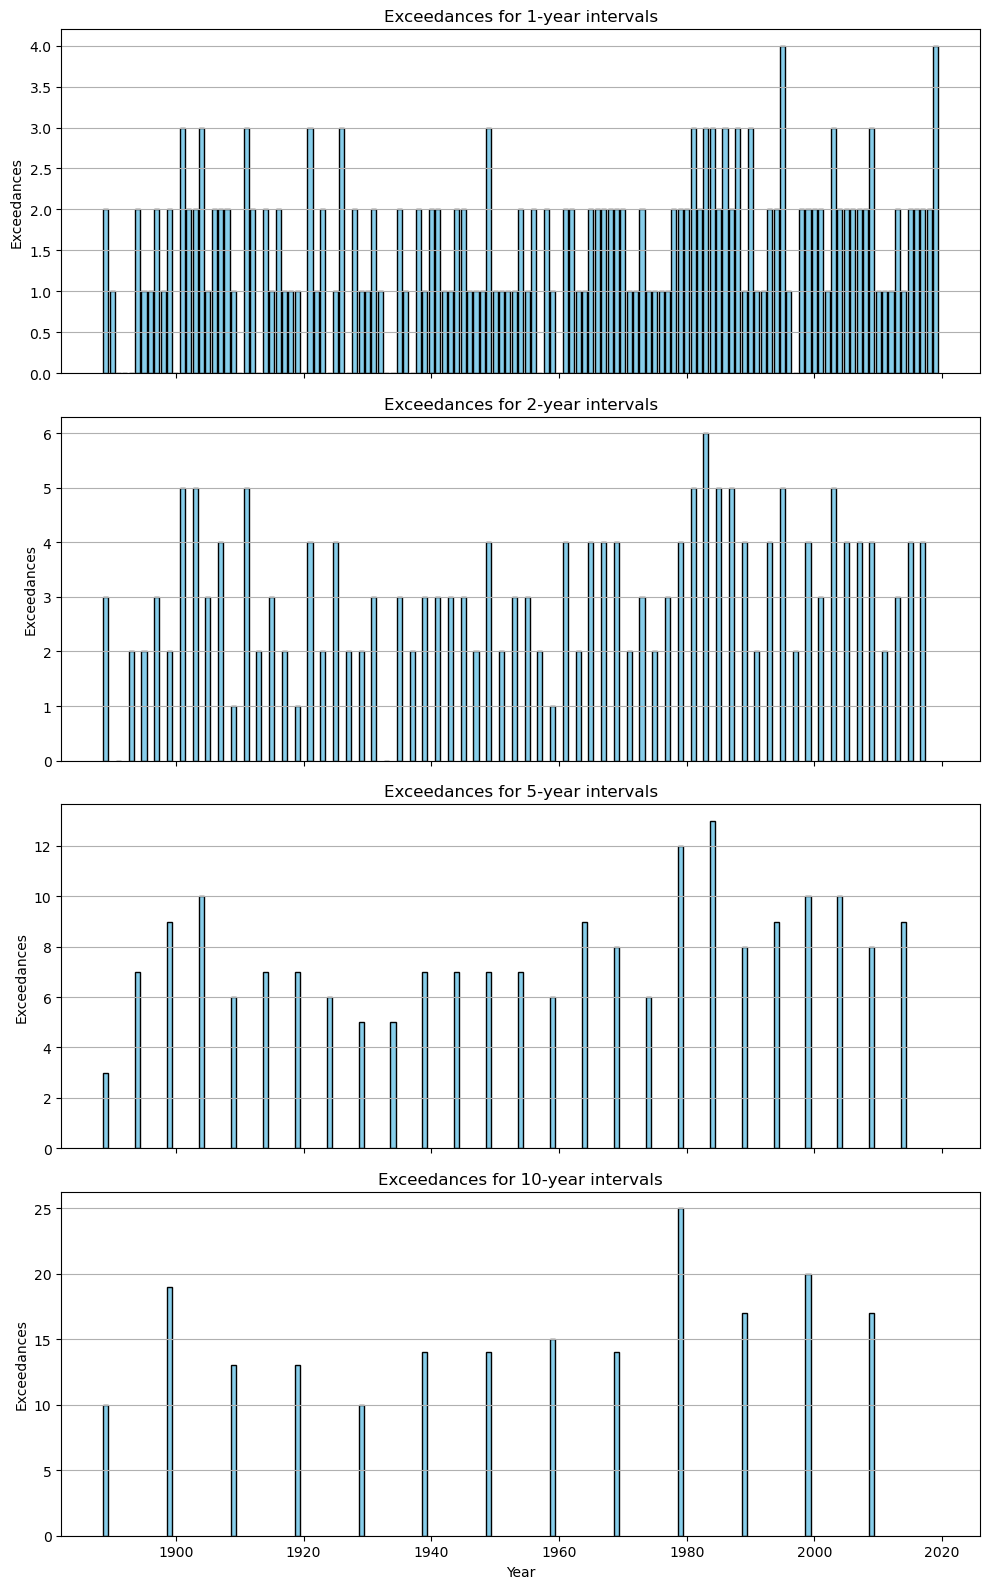

In [14]:
import matplotlib.pyplot as plt

# Define the intervals for grouping
intervals = [1, 2, 5, 10]  # years
results = {}

for interval in intervals:
    # Create bins based on the interval
    start_year = peak_times_un.dt.year.min()
    end_year = peak_times_un.dt.year.max()
    bins = range(start_year, end_year + 1, interval)
    
    # Group by bins
    peak_bins = pd.cut(peak_times_un.dt.year, bins=bins, right=False, labels=bins[:-1])
    exceedances = peak_bins.value_counts().sort_index()
    
    # Store the results for this interval
    results[f"{interval}-year"] = exceedances

# Plot the results
fig, axes = plt.subplots(len(intervals), 1, figsize=(10, len(intervals) * 4), sharex=True)

for i, (key, value) in enumerate(results.items()):
    axes[i].bar(value.index.astype(int), value.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Exceedances for {key} intervals")
    axes[i].set_ylabel("Exceedances")
    axes[i].grid(axis='y')

# Common X-axis label
axes[-1].set_xlabel("Year")

# Adjust layout
plt.tight_layout()
plt.show()


For the stationary time series, peak over threshold is also applied to find the extreme values. To compare the results, it is preferable to use the same threshold. 
The stationary time series are obtained by subtracting the annual means from the water level observations. 

The average of the annual mean water levels is 97.24 cm + NAP. To obtain a comparable threshold for the stationary time series, this value is subtracted from the orgiginal threshold of 200 cm + NAP. 
Therefore extreme values of the stationary time series are evaluated with a threshold of 102.76 cm + NAP and a declustering time of 4 days as well. 

Using these values a total of 198 extremes is obtained. No clear trend in the extremes is observed, which means that the hypothesis of stationarity can not be rejected based on this information. 

Threshold defined: 102.76 m.
Declustering time is: 96 hours.
The shape of the sampled extremes is: 198


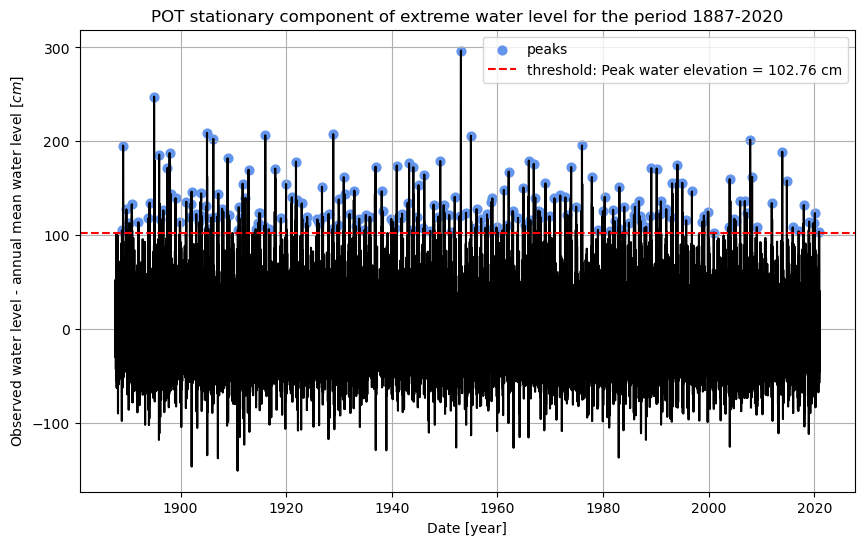

In [160]:
## Define the threshold
threshold = 200 - 97.24

print(f'Threshold defined: {threshold} m.')
distance = 24 * 4
print(f'Declustering time is: {distance} hours.')
peaks, _ = find_peaks((df['Elevation_Stationary']), height=threshold, distance=distance)
print('The shape of the sampled extremes is:', peaks.shape[0])

peak_times = df['Datetime'].iloc[peaks]

# Plot exceedances on the time series of all observations
plt.figure(figsize=(10, 6))
plt.plot(df['Datetime'], df['Elevation_Stationary'],'k')
plt.scatter(df.iloc[peaks, 0], df.iloc[peaks, 4], 40, color='cornflowerblue', label='peaks')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'threshold: Peak water elevation = {threshold} cm')
plt.xlabel('Date [year]')
plt.ylabel('Observed water level - annual mean water level [$cm$]')
plt.legend()
plt.title('POT stationary component of extreme water level for the period 1887-2020')

# plt.title(f'Peaks selected by POT for dataset with a declustering time of {distance} hours') # title already in Google docs
plt.grid()
plt.savefig('figures/POT_timeseries.png')

To evaluate the amount of extreme values for the assumed stationary series as well, they are counted and plotted over time. For time intervals of 1, 2, 5 and 10 years, 200 cm + NAP exceedances are plotted below. The amount of observations is definately not increasing over time. A slight decrease can even be observed. If this trend is significant, it would mean that this time series is not stationary by only taking out the trend in the mean. 



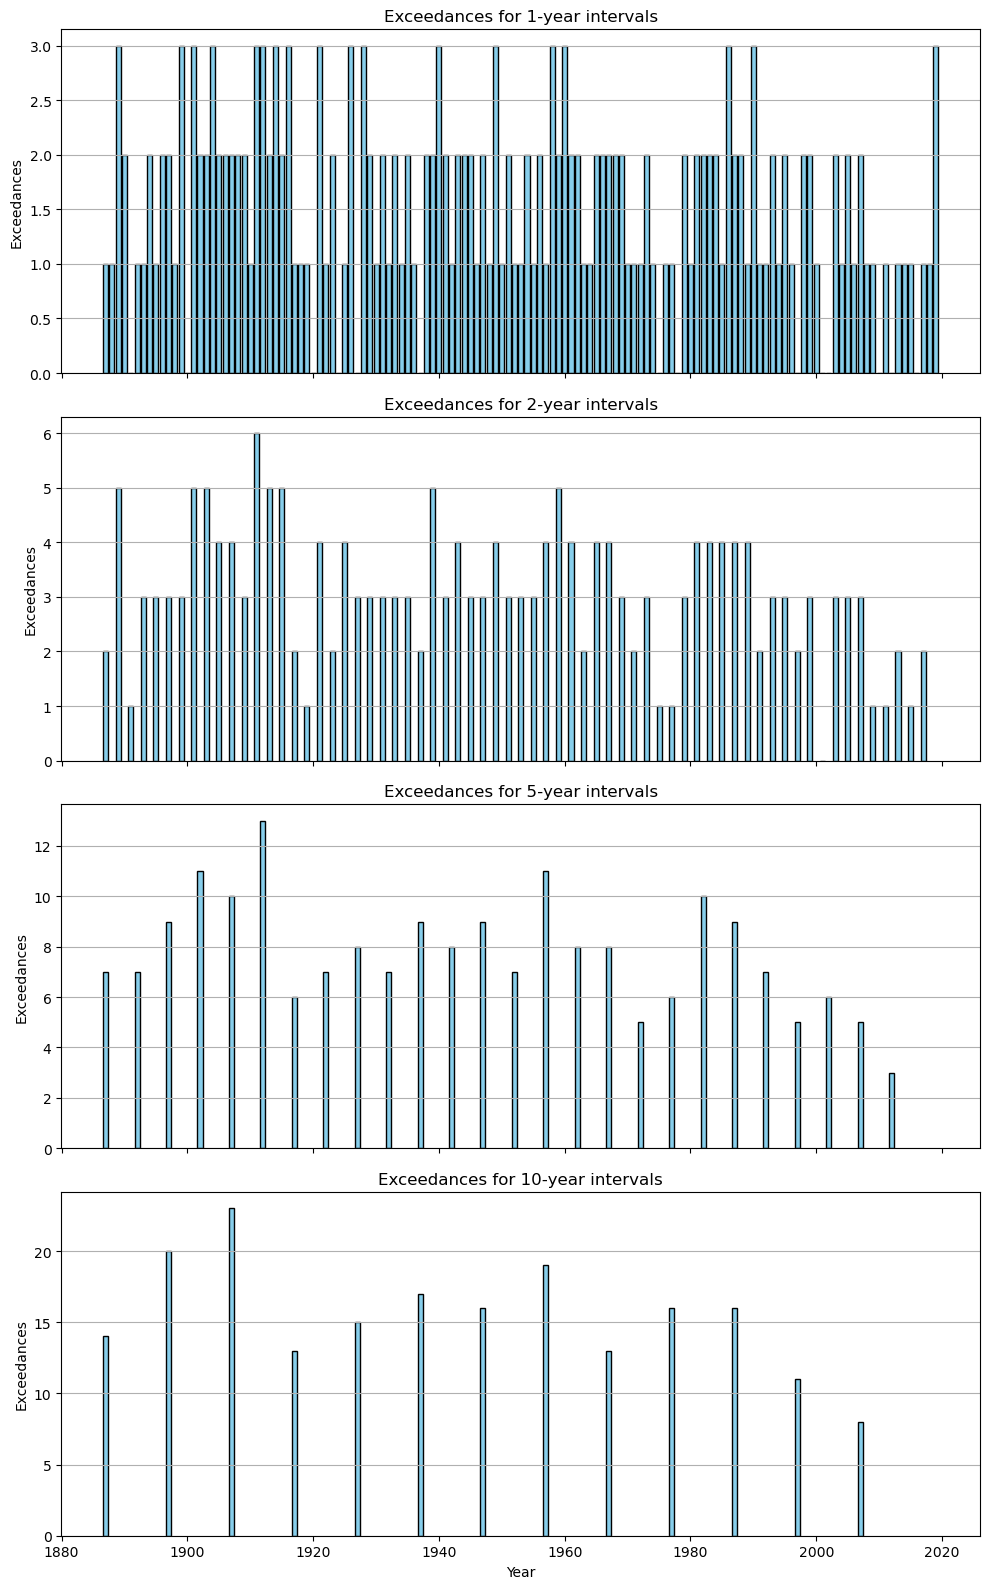

In [16]:
import matplotlib.pyplot as plt

# Define the intervals for grouping
intervals = [1, 2, 5, 10]  # years
results = {}

for interval in intervals:
    # Create bins based on the interval
    start_year = peak_times.dt.year.min()
    end_year = peak_times.dt.year.max()
    bins = range(start_year, end_year + 1, interval)
    
    # Group by bins
    peak_bins = pd.cut(peak_times.dt.year, bins=bins, right=False, labels=bins[:-1])
    exceedances = peak_bins.value_counts().sort_index()
    
    # Store the results for this interval
    results[f"{interval}-year"] = exceedances

# Plot the results
fig, axes = plt.subplots(len(intervals), 1, figsize=(10, len(intervals) * 4), sharex=True)

for i, (key, value) in enumerate(results.items()):
    axes[i].bar(value.index.astype(int), value.values, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Exceedances for {key} intervals")
    axes[i].set_ylabel("Exceedances")
    axes[i].grid(axis='y')

# Common X-axis label
axes[-1].set_xlabel("Year")

# Adjust layout
plt.tight_layout()
plt.show()


To find the amount of peaks that are unaccounted for because of the declustering time, these events are counted. It can be concluded that a declustering time is not required, there are no consecutive events are found. 

In [115]:
import pandas as pd

# Define the time difference threshold (e.g., two weeks = 14 days)
time_threshold = pd.Timedelta(days=4)

# Reset indices to ensure alignment
peak_times = peak_times.reset_index(drop=True)
time_differences = peak_times.diff()

# Find instances where the time difference is less than the threshold
close_extremes = time_differences[time_differences <= time_threshold]

# Get the indices of the peaks that are close to each other
close_extreme_indices = close_extremes.index

# Print the results
print(f"Number of close extremes: {len(close_extreme_indices)}")
print("Close extremes occurred at the following times:")
for idx in close_extreme_indices:
    print(f"- {peak_times[idx - 1]} and {peak_times[idx]} (Difference: {time_differences[idx]})")

# Optional: Filter the peaks DataFrame for closer inspection
close_extreme_pairs = pd.DataFrame({
    "First Peak": peak_times[close_extreme_indices - 1].values,
    "Second Peak": peak_times[close_extreme_indices].values,
    "Time Difference": time_differences[close_extreme_indices].values
})

# Display the DataFrame
print(close_extreme_pairs)

Number of close extremes: 0
Close extremes occurred at the following times:
Empty DataFrame
Columns: [First Peak, Second Peak, Time Difference]
Index: []


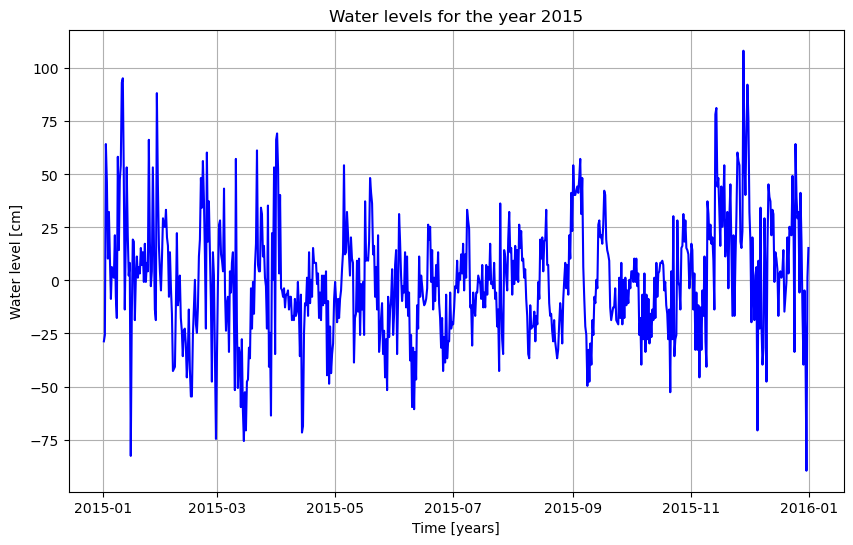

In [19]:
## Plot values for the year 2015
df_2015 = df[df['Datetime'].dt.year == 2015]
plt.figure(figsize=(10,6))
plt.plot(df_2015['Datetime'], df_2015['Elevation_Stationary'], color = 'blue')
plt.xlabel('Time [years]')
plt.ylabel('Water level [cm]')
plt.title('Water levels for the year 2015')
plt.grid()

## Non-stationary analysis

**Non-stationary analysis**:The stochastic component is given by `df['Elevation_Stationary']`. We will fit a GEV to the stochastic componant and derive the parameters of the distribution.

(-0.32131070407540474, 117.8907335953437, 15.900273474188946)


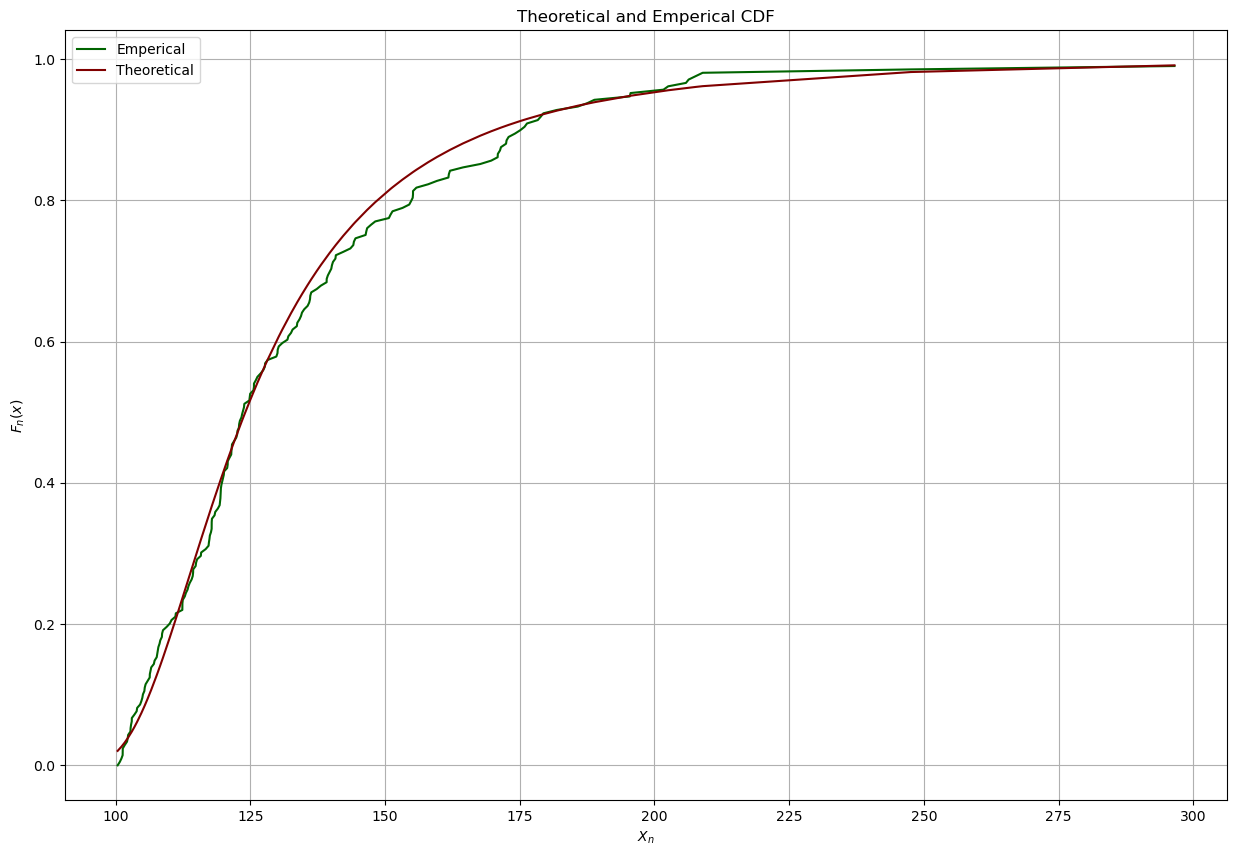

In [22]:
## Import necessary packages
from scipy import stats
from scipy.stats import norm
from scipy.stats import genextreme as gev
from scipy.stats import genpareto as gpd

array = np.array(df.iloc[peaks, 4])

## Define the empirical CDF 
def ecdf(data):
    n = len(data)
    ecdf = []
    for i in range(0, n):
        ecdf.append(i / (len(data)+1))
    return ecdf

## Fit the GEV to the stochastic component
gev_par_stoch = gev.fit(array, loc = array.mean(), scale = array.std())
xi, mu, sigma = gev_par_stoch
print(gev_par_stoch)

## Plot the empirical and theoretical CDF
emperical = ecdf(np.sort(array))
theoretical = gev.cdf(np.sort(array), xi, mu, sigma)

plt.figure(figsize=(15,10))
plt.plot(np.sort(array), emperical, color = 'darkgreen', label = 'Emperical')
plt.plot(np.sort(array), theoretical, color = 'maroon', label = 'Theoretical')
plt.xlabel(r'$X_{n}$')
plt.ylabel(r'$F_{n}(x)$')
plt.title('Theoretical and Emperical CDF')
plt.grid()
plt.legend()
plt.show()

The parameters of the stationary signal have now been found and are the following:
- shape parameter $\xi$ = -0.32131
- location parameter $\mu$ = 117.8907
- scale parameter $\sigma$ = 15.900

From the yearly maxima signal it can be observed that the timeseries has to be devided into two distinctive parts, with both different relationships for the signal. The signal is devided up into before and after 1970. In other words, the non-stationary part will be added back into the signal, this is firstly done for the block after 1970.

[ 3.23115478e-01 -5.32923738e+02]
114.92279652319087
[200 200 200 201 201 202 202 203 203 203 204 204 204 205 207 207 207 207
 207 208 209 209 209 210 210 211 212 212 214 214 214 214 215 216 216 217
 217 219 220 220 221 221 223 223 224 226 227 227 228 228 228 228 229 231
 232 233 233 234 235 236 236 236 238 238 238 238 238 238 240 240 242 242
 243 244 247 247 247 247 249 250 251 253 264 265 265 267 271 272 275 277
 279 279 284 288 298 303 318]


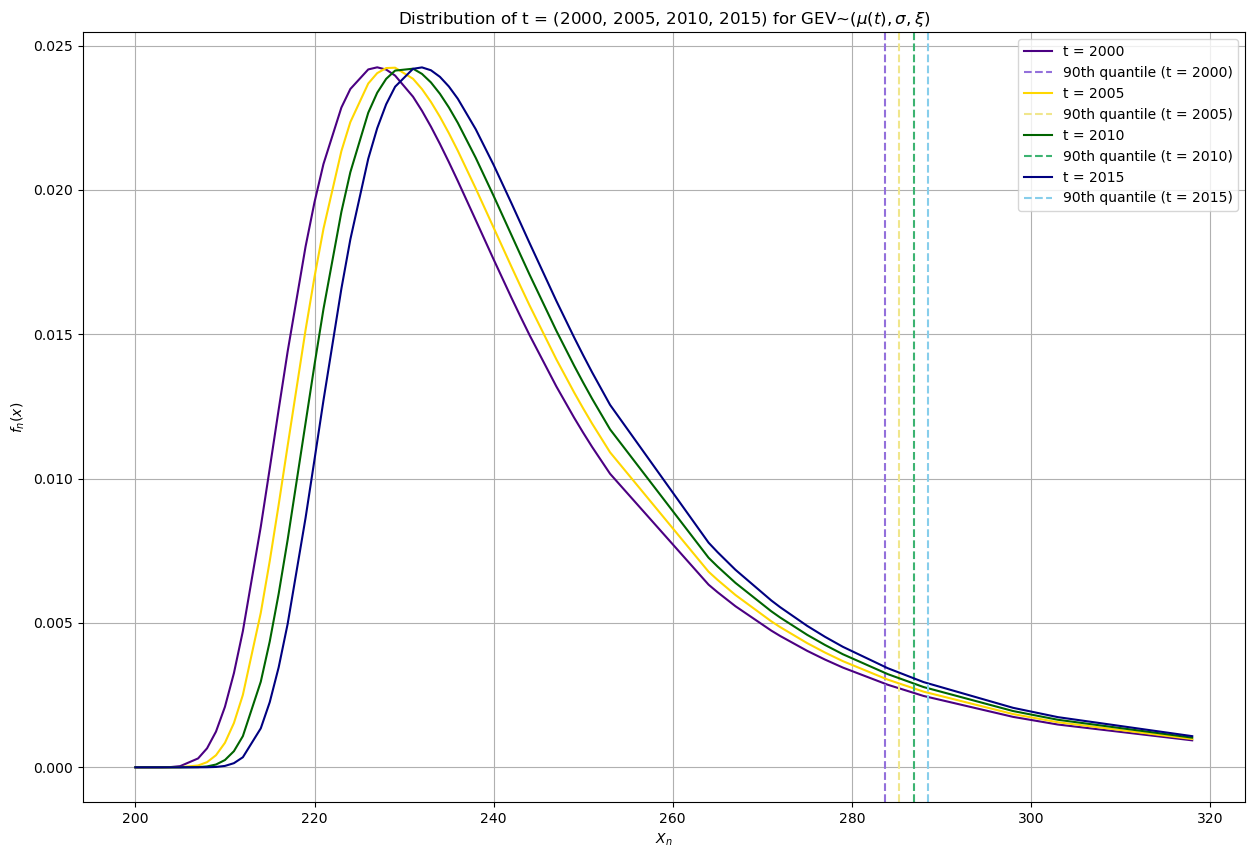

In [24]:
# Filter the DataFrame for dates after 1970
df_a1970 = df[df['Datetime'].dt.year >= 1970]
# Filter the yearly average for dates after 1970
YA_a1970 = df_a1970['Yearly_Avg']

## Linear fit will be found 
linmodel = np.polyfit(np.array(df_a1970['Year']), np.array(YA_a1970),1)
print(linmodel)
lin_new = np.poly1d(linmodel)
print(lin_new(2005))

## New mu value
mu0 = mu
def mu_new(t):
    mu_new = mu0 + lin_new(t)
    return mu_new

##
peaks_a1970 = np.array(peaks_un)[df.loc[peaks_un, 'Datetime'].dt.year >= 1970]
peaks_a1970_un = df.iloc[peaks_a1970, 1].values

## Calculate pdf for time step 2000, 2005, 2010, 2015
sorted_peaks = np.sort(np.array(peaks_a1970_un))
print(sorted_peaks)
f_mu2000 = gev.pdf(sorted_peaks, xi, mu_new(2000), sigma)
f_mu2005 = gev.pdf(sorted_peaks, xi, mu_new(2005), sigma)
f_mu2010 = gev.pdf(sorted_peaks, xi, mu_new(2010), sigma)
f_mu2015 = gev.pdf(sorted_peaks, xi, mu_new(2015), sigma)

## Find 90th quantile
quant90_2000 = gev.ppf(0.9, xi, mu_new(2000), sigma)
quant90_2005 = gev.ppf(0.9, xi, mu_new(2005), sigma)
quant90_2010 = gev.ppf(0.9, xi, mu_new(2010), sigma)
quant90_2015 = gev.ppf(0.9, xi, mu_new(2015), sigma)

## plot
plt.figure(figsize=(15,10))
plt.plot(sorted_peaks, f_mu2000, color = 'indigo', label = 't = 2000')
plt.axvline(x=quant90_2000, color = 'mediumpurple', linestyle = '--', label = '90th quantile (t = 2000)')
plt.plot(sorted_peaks, f_mu2005, color = 'gold', label = 't = 2005')
plt.axvline(x=quant90_2005, color = 'khaki', linestyle = '--', label = '90th quantile (t = 2005)')
plt.plot(sorted_peaks, f_mu2010, color = 'darkgreen', label = 't = 2010')
plt.axvline(x=quant90_2010, color = 'mediumseagreen', linestyle = '--', label = '90th quantile (t = 2010)')
plt.plot(sorted_peaks, f_mu2015, color = 'navy', label = 't = 2015')
plt.axvline(x=quant90_2015, color = 'skyblue', linestyle = '--', label = '90th quantile (t = 2015)')
plt.xlabel(r'$X_{n}$')
plt.ylabel(r'$f_{n}(x)$')
plt.title(r'Distribution of t = (2000, 2005, 2010, 2015) for GEV~($\mu(t), \sigma, \xi$)')
plt.legend()
plt.grid()
plt.show()

In [25]:
## Lets estimate the quantile for the year 2100
## For this we assume that the trend will not change for future t
quantiles_new = np.array([quant90_2000, quant90_2005, quant90_2010, quant90_2015])
t = np.array([2000, 2005, 2010, 2015])

#Find linear fit
linmodel2 = np.polyfit(t, quantiles_new, 1)
linfuture = np.poly1d(linmodel2)

## Find the 90th quantile for t = 2100
quant90_2100 = linfuture(2100)
print(f'The 90th quantile for the year 2100 is {quant90_2100:.3f}')


The 90th quantile for the year 2100 is 316.001


## Check on stationarity assumption
If only the location parameter $\mu$ is changing, this means that the shape and scale should stay the same for the emperical data over time. This can be tested by plotting the histograms of the extreme values from the different periods over time. 

For the test, the time series is divided in two equal parts: 1887-1953 and 1954-2020. The histogram of the extreme values is plotted. If these series have the same shape and scale parameter, this would result in a histogram with a similar amount of observations an an overlapping shape. 

Looking at the results, the shape of the histogram seems pretty similar. However, in 1887-1953 113 extremes are observed, while there are only 95 between 1994-2020. Although 198 datapoints in total is little to draw conclusions, this is a quite a large difference, indication that something else than the mean annual water level might have changed as well. This means that the series is not stationary if a trend in mean water levels is extracted as the deterministic component. 

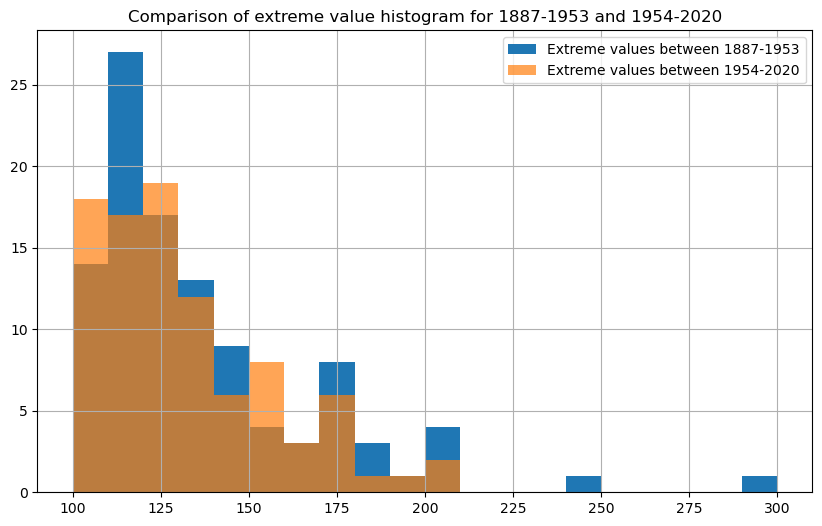

The amount of extremes in 1887-1953 is: 105
The amount of extremes in 1954- is: 93


In [246]:
## Investigate the shape of the histogram for the detrended/stationary time series
#df['Elevation_Stationary']
peaks_first10 = np.array(peaks)[df.loc[peaks, 'Datetime'].dt.year <= 1953]
peaks_first10 = df.iloc[peaks_first10, 4].values
peaks_sorted_first = np.sort(np.array(peaks_first10))
f_first = gev.pdf(peaks_sorted_first, xi, mu, sigma)

#peaks_middle = np.array(peaks)[
#    (df.loc[peaks, 'Datetime'].dt.year >= 1950) & 
#    (df.loc[peaks, 'Datetime'].dt.year <= 2000)]
#peaks_middle = df.iloc[peaks_middle, 1].values

peaks_end = np.array(peaks)[df.loc[peaks, 'Datetime'].dt.year >= 1954]
peaks_end = df.iloc[peaks_end, 4].values
peaks_sorted_end = np.sort(np.array(peaks_end))
f_end = gev.pdf(peaks_sorted_end, xi, mu, sigma)

bin_edges = np.linspace(100, 300, 21)
plt.figure(figsize=(10,6))
plt.hist(peaks_first10, bins=bin_edges, label = 'Extreme values between 1887-1953')
plt.hist(peaks_end, bins = bin_edges, label='Extreme values between 1954-2020', alpha=0.7)
plt.title('Comparison of extreme value histogram for 1887-1953 and 1954-2020')
plt.legend()
plt.grid()
plt.show()


print('The amount of extremes in 1887-1953 is:', peaks_first10.shape[0])
print('The amount of extremes in 1954- is:', peaks_end.shape[0])

In [242]:
print(f"Scipy signal peaks count: {len(peaks)}")
print(f"Above threshold count: {len(df[df['Elevation_Stationary'].values >= threshold])}")

Scipy signal peaks count: 198
Above threshold count: 438


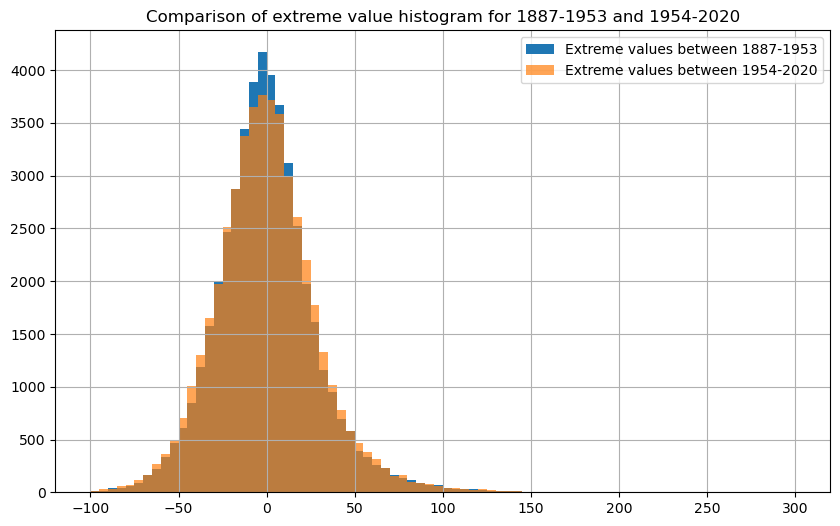

The amount of observations in 1887-1953 is: 46875
The amount of observations in 1954-2020 is: 47287


In [274]:
## Investigate the shape of the histogram for the detrended/stationary time series
levels = df['Elevation_Stationary']
levels_first = levels[df['Datetime'].dt.year <= 1953].values
levels_end = levels[df['Datetime'].dt.year >= 1954].values

bin_edges = np.linspace(-100, 300, 81)
plt.figure(figsize=(10,6))
plt.hist(levels_first, bins=bin_edges, label = 'Extreme values between 1887-1953')
#plt.hist(peaks_middle, bins = 20)
plt.hist(levels_end, bins = bin_edges, label='Extreme values between 1954-2020', alpha=0.7)
plt.title('Comparison of extreme value histogram for 1887-1953 and 1954-2020')
plt.legend()
plt.grid()
plt.show()

print('The amount of observations in 1887-1953 is:', levels_first.shape[0])
print('The amount of observations in 1954-2020 is:', levels_end.shape[0])

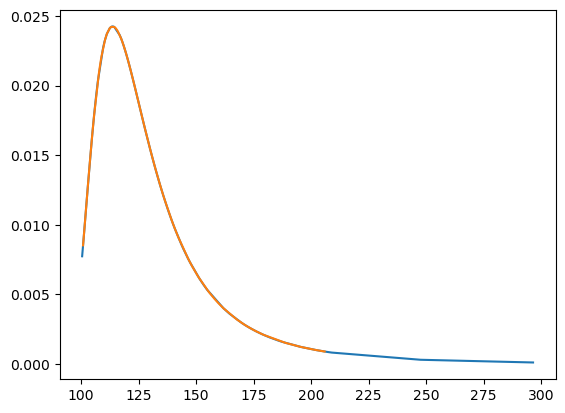

In [27]:
plt.plot(peaks_sorted_first, f_first, label = 'PDF-First Half')
plt.plot(peaks_sorted_end, f_end, label = 'PDF-Second Half')